In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import dask
import cartopy.crs as ccrs
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
plt.style.use("tableau-colorblind10")

In [3]:
base = "zc-emu-monthly-seed5-m{init}-30d-v1-{run_type}"
run_types = ["online", "offline"]
inits = [f"{i:02d}" for i in range(1, 13)]

In [4]:
dt = 900 # s
seconds_per_day = 60 * 60 * 24  # seconds/min * min/hr * hr/day
m_to_mm = 1000

# from physcons.f
cp = 1.0046e3 # J / (kg K)
gravity = 9.80665 # m / s^2
lv = 2.5e6  # J / kg water
rho_water = 1000.0 # kg / m^3

In [5]:
diag_key = "surface_precipitation_due_to_zhao_carr_emulator"
wrapper_key = "total_precipitation"

In [6]:
def kg_m2_s_to_mm_day(da):
    return da * seconds_per_day / rho_water * m_to_mm

def m_to_mm_day(da):
    return da / dt * m_to_mm * seconds_per_day


In [18]:
zc_emu_pr = vcm.zonal_average_approximate(data.lat, kg_m2_s_to_mm_day(data[diag_key]))
total_pr = vcm.zonal_average_approximate(data.lat, m_to_mm_day(data[wrapper_key]))

[########################################] | 100% Completed | 8.11 ss
[########################################] | 100% Completed | 7.13 ss


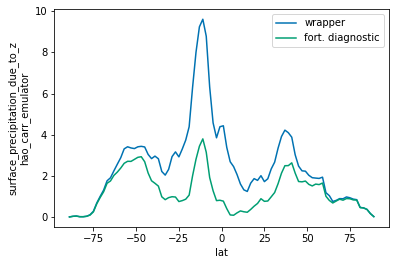

In [19]:
with ProgressBar():
    total_pr.isel(time=slice(0,40)).mean(dim="time").plot(label="wrapper")
    zc_emu_pr.isel(time=slice(0,40)).mean(dim="time").plot(label="fort. diagnostic")
plt.legend()
plt.show()


This confirms total precip is from the wrapper.  Includes Zhao-Carr precip and convective precipitation.  Useful for whether we are still at the correct climatology.

In [ ]:
@common.memoize_xarray_out
def get_pr_zonal_and_hist(group):
    data = common.open_group(group)
    emu_key =  "surface_precipitation_due_to_zhao_carr_emulator"
    fort_key =  "surface_precipitation_due_to_zhao_carr_physics"
    pr = kg_m2_s_to_mm_day(data[[emu_key, fort_key]])
    pr["total_precipitation"] = m_to_mm_day(data["total_precipitation"])


    bin_edges = np.logspace(-3, 2.5, 50)
    counts_emu, _ = dask.array.histogram(pr[emu_key], bins=bin_edges)
    counts_fort, _ = dask.array.histogram(pr[fort_key], bins=bin_edges)

    zonal = vcm.zonal_average_approximate(data.lat, pr)

    return xr.Dataset(
        {
            "emulator": xr.DataArray(data=counts_emu, dims="bins").load(),
            "fortran": xr.DataArray(data=counts_fort, dims="bins").load(),                                 
        },
        coords = {"bin_edges": ("bin_edges", bin_edges)}
    ).merge(zonal.load())

In [5]:
groups = [base.format(init=init, run_type=run_type) for init, run_type in product(inits, run_types)]
args = list(product(inits, run_types))

In [53]:
jobs = [delayed(get_pr_zonal_and_hist)(g) for g in groups]
results = Parallel(n_jobs=12)(jobs)

In [8]:
def gather(groups, results):
    out = defaultdict(list)
    for g, res in zip(groups, results):
        if "offline" in g:
            out["offline"].append(res)
        else:
            out["online"].append(res)

    offline = xr.concat(out["offline"], dim="init")
    online = xr.concat(out["online"], dim="init")

    return offline, online


In [54]:
offline_pr, online_pre = gather(groups, results)

## Zonal Precipitation

Total precip from wrapper

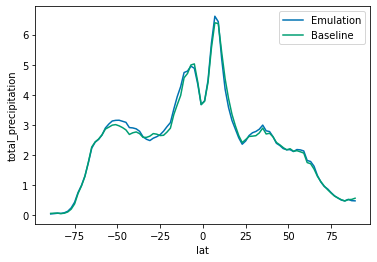

In [58]:
online_pr["total_precipitation"].mean(dim=["init", "time"]).plot(label="Emulation")
offline_pr["total_precipitation"].mean(dim=["init", "time"]).plot(label="Baseline")
plt.legend()
plt.show()

Online ZC precip vs. offline fortran precip

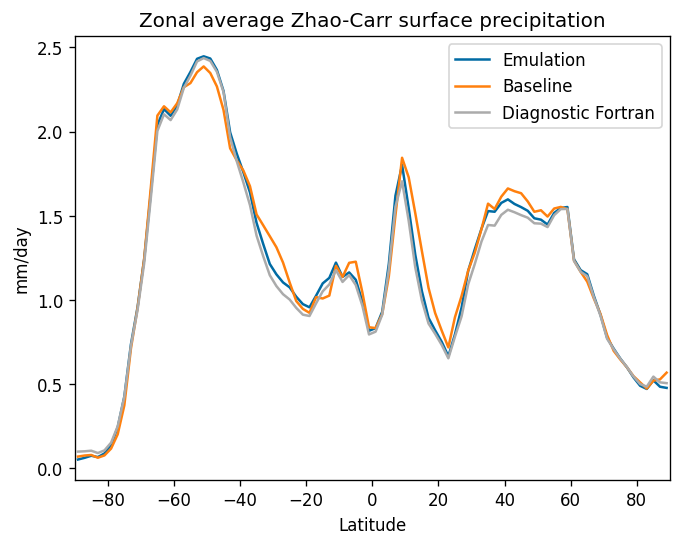

In [91]:
plt.figure(dpi=120)
online_pr["surface_precipitation_due_to_zhao_carr_emulator"].mean(dim=["init", "time"]).plot(label="Emulation")
offline_pr["surface_precipitation_due_to_zhao_carr_physics"].mean(dim=["init", "time"]).plot(label="Baseline")
online_pr["surface_precipitation_due_to_zhao_carr_physics"].mean(dim=["init", "time"]).plot(label="Diagnostic Fortran")
plt.ylabel("mm/day")
plt.xlabel("Latitude")
plt.xlim(-90,90)
plt.title("Zonal average Zhao-Carr surface precipitation")
plt.legend()
plt.show()

Online ZC precip vs the piggy-backed diagnostic

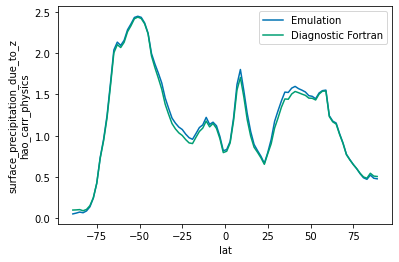

In [61]:
online_pr["surface_precipitation_due_to_zhao_carr_emulator"].mean(dim=["init", "time"]).plot(label="Emulation")
online_pr["surface_precipitation_due_to_zhao_carr_physics"].mean(dim=["init", "time"]).plot(label="Diagnostic Fortran")
plt.legend()
plt.show()

## Precip distribution

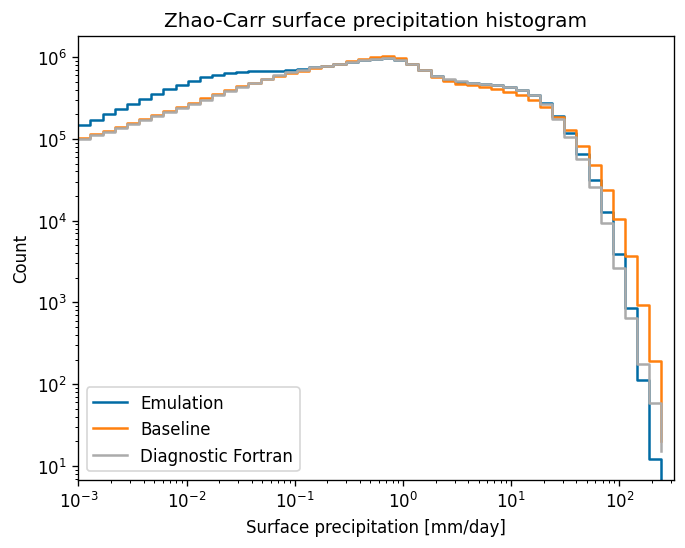

In [92]:
fig, ax = plt.subplots(dpi=120)
bins = online_pr["bin_edges"].values
count_emu = online_pr["emulator"].sum(dim="init").values
count_diag_fort = online_pr["fortran"].sum(dim="init").values
count_fort = offline_pr["fortran"].sum(dim="init").values
plt.step(bins[:-1], count_emu, where="post", label="Emulation")
plt.step(bins[:-1], count_fort, where="post", label="Baseline")
plt.step(bins[:-1], count_diag_fort, where="post", label="Diagnostic Fortran")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(bins[0], bins[-1])
plt.legend()
plt.xlabel("Surface precipitation [mm/day]")
plt.ylabel("Count")
plt.title("Zhao-Carr surface precipitation histogram")
plt.show()

## Calculate some global mean metrics

In [9]:
@common.memoize_xarray_out
def get_pr_mse_bias(group):
    data = common.open_group(group)
    emulator = data["surface_precipitation_due_to_zhao_carr_emulator"]
    target = data["surface_precipitation_due_to_zhao_carr_physics"]

    mse = (emulator - target)**2
    mse_avg = vcm.weighted_average(mse, data.area, dims=["tile", "x", "y"])
    pr_avg = vcm.weighted_average(emulator, data.area, dims=["tile", "x", "y"])

    return xr.Dataset(
        data_vars={
            "mse": mse_avg.load(),
            "mean_precipitation": pr_avg.load()
        }
    )

In [10]:
jobs = [delayed(get_pr_mse_bias)(g) for g in groups]
results = Parallel(n_jobs=12)(jobs)

In [12]:
offline_metrics, online_metrics = gather(groups, results)

In [13]:
offline_metrics

<xarray.Dataset>
Dimensions:             (time: 2872, init: 12)
Coordinates:
  * time                (time) object 2016-01-31 03:00:00 ... 2017-01-30 00:0...
Dimensions without coordinates: init
Data variables:
    mse                 (init, time) float32 5.717e-12 5.193e-12 ... 6.824e-12
    mean_precipitation  (init, time) float32 1.603e-05 1.645e-05 ... 1.597e-05

In [26]:
print(f"Offline RMSE: {kg_m2_s_to_mm_day(np.sqrt(offline_metrics['mse'].mean()).values):1.2f} mm/day")
print(f"Online RMSE: {kg_m2_s_to_mm_day(np.sqrt(online_metrics['mse'].mean()).values):1.2f} mm/day")
print(f"Online bias: {kg_m2_s_to_mm_day(online_metrics['mean_precipitation'] - offline_metrics['mean_precipitation']).mean().values:1.2e} mm/day")

Offline RMSE: 0.22 mm/day
Online RMSE: 1.10 mm/day
Online bias: -7.11e-04 mm/day
